# Install required packages

In [ ]:
! pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.6 MB/s eta 0:00:00


# Check GPU status

In [ ]:
! nvidia-smi

Tue Mar 14 08:49:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import

In [ ]:
import os
import sys
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as A
import timm
import matplotlib.pyplot as plt

device = torch.device('cuda')

# Read Data

In [ ]:
! ls /content/drive/MyDrive/247_proj_cnn

'CNN-LSTM Hybrid with data preprocessing.ipynb'   fold_4_best_acc.ckpt
'CNN with data preprocessing.ipynb'		  person_test.npy
 EEG_loading.ipynb				  person_train_valid.npy
 fold_0_best_acc.ckpt				  X_test.npy
 fold_1_best_acc.ckpt				  X_train_valid.npy
 fold_2_best_acc.ckpt				  y_test.npy
 fold_3_best_acc.ckpt				  y_train_valid.npy


In [ ]:
os.chdir('/content/drive/MyDrive/247_proj_cnn')

In [ ]:
X_train_valid = np.load('X_train_valid.npy')
y_train_valid = np.load('y_train_valid.npy')

In [ ]:
X_train_valid.shape

(2115, 22, 1000)

In [ ]:
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Define dataset

In [ ]:
class BCIDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.encode_class = {769:0, 770:1, 771:2, 772:3}

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        x = torch.tensor(self.X[index,:,:]).float()
        y = self.y[index]
        y = self.encode_class[y]
        y = torch.tensor(y).long()
        # return x, y
        return x.unsqueeze(2), y
        # return torch.stack([x,x,x]), y


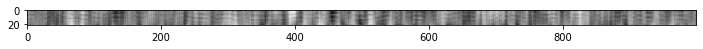

In [ ]:
plt.figure(figsize=(12,8))
plt.imshow(next(iter(BCIDataset(X_test, y_test)))[0], cmap='gray')

# Define model

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ELU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

class ERUConv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, mp_kernal_size, padding, dropout):
        super().__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, 
                              kernel_size = kernel_size, padding=padding)
        nn.init.xavier_uniform_(self.conv.weight)
        self.elu = nn.ELU()
        self.maxpool = nn.MaxPool2d(kernel_size = mp_kernal_size)
        self.BN = nn.BatchNorm2d(out_channel)
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x = self.elu(self.conv(x))
        x = self.maxpool(x)
        x = self.BN(x)
        x = self.dropout(x)
        return x

class ResTemporalCNN(nn.Module):
    def __init__(self, drop_out):
        super().__init__()

        self.conv_temp = nn.Conv2d(1, 1, (1, 5), stride = (1, 3)) # 3
        self.elu = nn.ELU()
        nn.init.xavier_uniform_(self.conv_temp.weight)

        self.res1 = ResidualBlock(22, 44)
        self.conv1 = ERUConv(44, 88, (10, 1), (2, 1), 'same', drop_out)
        self.conv2 = ERUConv(88, 168, (10, 1), (2, 1), 'same', drop_out)
        self.conv3 = ERUConv(168, 384, (10, 1), (2, 1), 'same', drop_out)
        
        self.fc = nn.Sequential(
            nn.Linear(384*41, 64), 
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(drop_out),
            nn.Linear(64,32),
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(32,4)
        )
    
    def forward(self, x):
        x = self.conv_temp(x.permute(0,3,1,2))
        print(x.shape)
        # x = self.elu(x)
        x = x.permute(0,2,3,1)

        x = self.res1(x)
        print(x.shape)
        x = self.conv1(x)
        print(x.shape)
        x = self.conv2(x)
        print(x.shape)
        x = self.conv3(x)
        print(x.shape)
        # print(x.shape)
        bs = x.size(0)
        x = x.view(bs, -1)
        x = self.fc(x)

        return x

model = ResTemporalCNN(0.5)
model(torch.randn(2,22,1000,1))

torch.Size([2, 1, 22, 332])
torch.Size([2, 44, 332, 1])
torch.Size([2, 88, 166, 1])
torch.Size([2, 168, 83, 1])
torch.Size([2, 384, 41, 1])


tensor([[ 0.2429,  0.3007,  0.4586,  0.0119],
        [-0.0837,  0.4738,  0.2870,  0.3750]], grad_fn=<AddmmBackward0>)

# Training and validation

## training configurations

In [ ]:
num_epochs = 100
lr=0.005
drop_out = 0.5
k = 5 # number of folds
batch_size = 64
num_worker = 8

In [ ]:
def train_valid_fold(X_train, y_train, X_valid, y_valid, fold_id):
    print('Building dataset...')
    bcidataset_train = BCIDataset(X_train, y_train)
    bcidataset_train_dl = torch.utils.data.DataLoader(bcidataset_train, batch_size=batch_size, num_workers=num_worker, shuffle=True)
    bcidataset_test = BCIDataset(X_valid, y_valid)
    bcidataset_test_dl = torch.utils.data.DataLoader(bcidataset_test, batch_size=batch_size, num_workers=num_worker, shuffle=False)

    print('Create new model...')
    model = ResTemporalCNN(drop_out)
    model = model.cuda()

    print('Setting up loss function, optimizer and scheduler...')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs,)

    # Training loop
    accuracy_list = []
    loss_by_epoch = []
    val_loss_by_epoch = []
    max_accuracy = 0
    best_model = model
    for epoch in tqdm(range(num_epochs)):
        losses = []
        model.train()
        for i, (inputs, labels) in enumerate(bcidataset_train_dl):
            inputs = inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss = np.mean(losses)
        loss_by_epoch.append(loss)
        
        # validate with the testing dataset
        predicted_label = []
        actual_label = []
        model.eval()
        val_losses = []
        for i, (inputs, labels) in enumerate(bcidataset_test_dl):
            inputs = inputs.cuda()
            actual_label += labels.tolist()
            labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            predicted = outputs.argmax(1)
            predicted_label += predicted.cpu().numpy().tolist()
        val_loss_by_epoch.append(np.mean(losses))
        predicted_label = torch.tensor(predicted_label)
        actual_label = torch.tensor(actual_label)
        accuracy = (np.array(actual_label) == np.array(predicted_label)).sum() / len(predicted_label)
        if accuracy > max_accuracy:
            print(f'Better accuracy found ({max_accuracy} -> {accuracy}), best model saved.')
            max_accuracy = accuracy
            torch.save(model.state_dict(), f'fold_{fold_id}_best_acc.ckpt')
        accuracy_list.append(accuracy)
        scheduler.step()

    axes[0].plot(accuracy_list)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Validation Accuracy')
    
    axes[1].plot(np.arange(10, num_epochs), loss_by_epoch[10:])
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Training Loss')

    axes[2].plot(np.arange(10, num_epochs), val_loss_by_epoch[10:])
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Validation Loss')



Building dataset...
Create new model...


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Setting up loss function, optimizer and scheduler...


  0%|          | 0/100 [00:00<?, ?it/s]

Better accuracy found (0 -> 0.33569739952718675), best model saved.
Better accuracy found (0.33569739952718675 -> 0.4515366430260047), best model saved.
Better accuracy found (0.4515366430260047 -> 0.4657210401891253), best model saved.
Better accuracy found (0.4657210401891253 -> 0.48699763593380613), best model saved.
Better accuracy found (0.48699763593380613 -> 0.5011820330969267), best model saved.
Better accuracy found (0.5011820330969267 -> 0.5460992907801419), best model saved.
Better accuracy found (0.5460992907801419 -> 0.5484633569739953), best model saved.
Better accuracy found (0.5484633569739953 -> 0.5791962174940898), best model saved.
Better accuracy found (0.5791962174940898 -> 0.5910165484633569), best model saved.
Better accuracy found (0.5910165484633569 -> 0.607565011820331), best model saved.
Better accuracy found (0.607565011820331 -> 0.6217494089834515), best model saved.
Better accuracy found (0.6217494089834515 -> 0.6288416075650118), best model saved.
Better 

  0%|          | 0/100 [00:00<?, ?it/s]

Better accuracy found (0 -> 0.3617021276595745), best model saved.
Better accuracy found (0.3617021276595745 -> 0.408983451536643), best model saved.
Better accuracy found (0.408983451536643 -> 0.4940898345153664), best model saved.
Better accuracy found (0.4940898345153664 -> 0.5059101654846335), best model saved.
Better accuracy found (0.5059101654846335 -> 0.5153664302600472), best model saved.
Better accuracy found (0.5153664302600472 -> 0.5366430260047281), best model saved.
Better accuracy found (0.5366430260047281 -> 0.5508274231678487), best model saved.
Better accuracy found (0.5508274231678487 -> 0.607565011820331), best model saved.
Better accuracy found (0.607565011820331 -> 0.6382978723404256), best model saved.
Better accuracy found (0.6382978723404256 -> 0.6477541371158393), best model saved.
Better accuracy found (0.6477541371158393 -> 0.6524822695035462), best model saved.
Better accuracy found (0.6524822695035462 -> 0.6619385342789598), best model saved.
Better accura

  0%|          | 0/100 [00:00<?, ?it/s]

Better accuracy found (0 -> 0.39952718676122934), best model saved.
Better accuracy found (0.39952718676122934 -> 0.44208037825059104), best model saved.
Better accuracy found (0.44208037825059104 -> 0.45390070921985815), best model saved.
Better accuracy found (0.45390070921985815 -> 0.5437352245862884), best model saved.
Better accuracy found (0.5437352245862884 -> 0.6170212765957447), best model saved.
Better accuracy found (0.6170212765957447 -> 0.6501182033096927), best model saved.
Better accuracy found (0.6501182033096927 -> 0.6643026004728132), best model saved.
Better accuracy found (0.6643026004728132 -> 0.6666666666666666), best model saved.
Better accuracy found (0.6666666666666666 -> 0.6690307328605201), best model saved.
Better accuracy found (0.6690307328605201 -> 0.6713947990543735), best model saved.
Better accuracy found (0.6713947990543735 -> 0.6879432624113475), best model saved.
Better accuracy found (0.6879432624113475 -> 0.6926713947990544), best model saved.
Bet

  0%|          | 0/100 [00:00<?, ?it/s]

Better accuracy found (0 -> 0.3900709219858156), best model saved.
Better accuracy found (0.3900709219858156 -> 0.4444444444444444), best model saved.
Better accuracy found (0.4444444444444444 -> 0.491725768321513), best model saved.
Better accuracy found (0.491725768321513 -> 0.5390070921985816), best model saved.
Better accuracy found (0.5390070921985816 -> 0.6028368794326241), best model saved.
Better accuracy found (0.6028368794326241 -> 0.6052009456264775), best model saved.
Better accuracy found (0.6052009456264775 -> 0.6122931442080378), best model saved.
Better accuracy found (0.6122931442080378 -> 0.624113475177305), best model saved.
Better accuracy found (0.624113475177305 -> 0.6501182033096927), best model saved.
Better accuracy found (0.6501182033096927 -> 0.6524822695035462), best model saved.
Better accuracy found (0.6524822695035462 -> 0.6666666666666666), best model saved.
Better accuracy found (0.6666666666666666 -> 0.6690307328605201), best model saved.
Better accura

  0%|          | 0/100 [00:00<?, ?it/s]

Better accuracy found (0 -> 0.458628841607565), best model saved.
Better accuracy found (0.458628841607565 -> 0.4728132387706856), best model saved.
Better accuracy found (0.4728132387706856 -> 0.4799054373522459), best model saved.
Better accuracy found (0.4799054373522459 -> 0.508274231678487), best model saved.
Better accuracy found (0.508274231678487 -> 0.5815602836879432), best model saved.
Better accuracy found (0.5815602836879432 -> 0.6217494089834515), best model saved.
Better accuracy found (0.6217494089834515 -> 0.6335697399527187), best model saved.
Better accuracy found (0.6335697399527187 -> 0.6926713947990544), best model saved.
Better accuracy found (0.6926713947990544 -> 0.7092198581560284), best model saved.
Better accuracy found (0.7092198581560284 -> 0.7139479905437353), best model saved.
Better accuracy found (0.7139479905437353 -> 0.7210401891252955), best model saved.
Better accuracy found (0.7210401891252955 -> 0.723404255319149), best model saved.
Better accurac

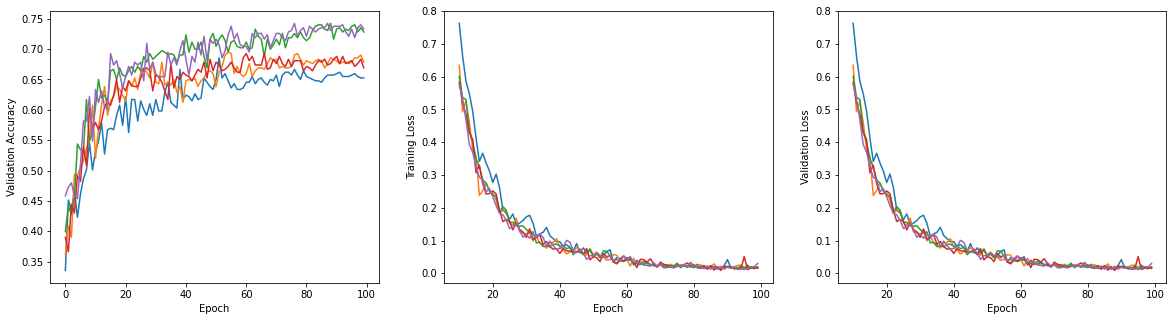

In [ ]:
from sklearn.model_selection import KFold

# Split the data into k folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes = axes.flatten()

# Loop over each fold
for fold, (train_index, test_index) in enumerate(kf.split(X_train_valid)):

    # Get the training and test sets for this fold
    X_train, X_valid = X_train_valid[train_index], X_train_valid[test_index]
    y_train, y_valid = y_train_valid[train_index], y_train_valid[test_index]
    train_valid_fold(X_train, y_train, X_valid, y_valid, fold)

# Predict the test dataset

In [ ]:
bcidataset_test = BCIDataset(X_test, y_test)
bcidataset_test_dl = torch.utils.data.DataLoader(bcidataset_test, batch_size=64, num_workers=8, shuffle=False)

In [ ]:
pred_proba_list = []
for fold_id in range(k):
    model = ResTemporalCNN(drop_out)
    model.load_state_dict(torch.load(f'fold_{fold_id}_best_acc.ckpt'))
    model = model.cuda()
    # validate with the testing dataset
    predicted_label = []
    predicted_proba = []
    actual_label = []
    model.eval()
    for i, (inputs, labels) in enumerate(bcidataset_test_dl):
        inputs = inputs.cuda()
        actual_label += labels.tolist()
        outputs = model(inputs)
        predicted_label += outputs.argmax(1).cpu().numpy().tolist()
        predicted_proba += outputs.softmax(1).cpu().tolist()
    pred_proba_list.append(predicted_proba)

In [ ]:
test_accuracy = (np.array(pred_proba_list).mean(0).argmax(1) == np.array(actual_label)).sum() / len(np.array(actual_label))

In [ ]:
print(f'Final test accuracy is {test_accuracy: .5f}')

Final test accuracy is 0.73584


<AxesSubplot:>

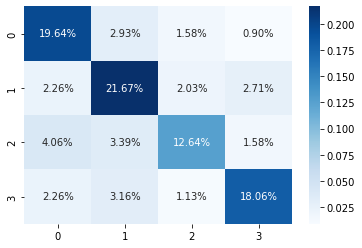

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(np.array(actual_label), np.array(pred_proba_list).mean(0).argmax(1))

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')